## Vehicle detection project
---------------------------

### Plan

1. Exploration
    1. Read all test file and Car/Non car file and test in on the lesson functions.
2. Buildng classifier
    1. Take data from car/Non Car and extarct feature to make X any Y
    2. Use SVM to make classifier and save as pickle
    3. Use Grid search for optimal parameter cross validation
    4. Test accuracy on validation set
3. Detecting Vehicles
    1. Extarct all features on single image
    2. Using sliding window extarct for the window. Have to run window for multiple size and in selected area
    3. Resize window extart features
    4. Prediction using saved SVM
    5. Make heat map apply threhold and find final bounding box.
4. Video
    1. Make pipeline for predicting vehicle and try on test_video
    2. Combine with lane detection
    3. Run on project video
5. Write up

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
import os
import time
from glob import glob
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from scipy.ndimage.measurements import label
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib
from project_func import *
from ipywidgets import interact, interactive, fixed
from moviepy.editor import VideoFileClip
from IPython.display import HTML

/home/eudie/miniconda3/envs/carnano/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Building Classifier to detect vehicles

In [2]:
DATA_FOLDER = '/media/eudie/D0845F29845F1178/Project_Data/sdnd/vehicle_detection/'

In [3]:
from glob import glob
vehicles = [y for x in os.walk(DATA_FOLDER + 'vehicles') for y in glob(os.path.join(x[0], '*.png'))]
non_vehicles = [y for x in os.walk(DATA_FOLDER + 'non-vehicles') for y in glob(os.path.join(x[0], '*.png'))]

### Parameters to tune 

In [4]:
cspace = 'YCrCb'
spatial_size = (32, 32)
hist_bins = 32
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'

In [5]:
car_features = extract_features(vehicles, cspace=cspace, spatial_size=spatial_size,
                        hist_bins=hist_bins, hist_range=(0, 256),  orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel)

notcar_features = extract_features(non_vehicles, cspace=cspace, spatial_size=spatial_size,
                        hist_bins=hist_bins, hist_range=(0, 256),  orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel)

In [6]:
X = np.vstack((car_features, notcar_features)).astype(np.float64)                      
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

In [7]:
svc = LinearSVC()
svc.fit(X_train, y_train)

print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))


Test Accuracy of SVC =  0.9927


In [9]:
dict_to_save = {'clf': svc,
                'X_scaler': X_scaler,
                'cspace': cspace,
                'spatial_size': spatial_size,
                'hist_bins': hist_bins,
                'orient': orient,
                'pix_per_cell': pix_per_cell,
                'cell_per_block': cell_per_block,
                'hog_channel':hog_channel}

pickle.dump(dict_to_save, open('classifier_and_parameters.pkl', 'wb'))

### Reusing saved model and tuned parameters

In [2]:
model = pickle.load(open('classifier_and_parameters.pkl', 'rb'))

svc = model['clf']
X_scaler = model['X_scaler']
cspace = model['cspace']
spatial_size = model['spatial_size']
hist_bins = model['hist_bins']
orient = model['orient']
pix_per_cell = model['pix_per_cell']
cell_per_block = model['cell_per_block']
hog_channel = model['hog_channel']

In [3]:
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

x_start_stop = [None, None]

In [4]:
def pipeline(image):
    
    draw_image = np.copy(image)


    all_size_windows = []
    for i in range(1, 6):
        size = np.int(64 * i/2)
        y_start_stop = [400,  478 + size] 

        windows = slide_window(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                            xy_window=(size, size), xy_overlap=(0.7, 0.7))
        all_size_windows.extend(windows)

    hot_windows = search_windows(image, all_size_windows, svc, X_scaler, color_space=cspace, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       

    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    heat = add_heat(heat,hot_windows)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,2)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)

    return draw_img

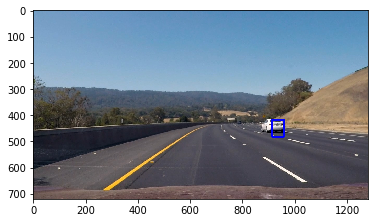

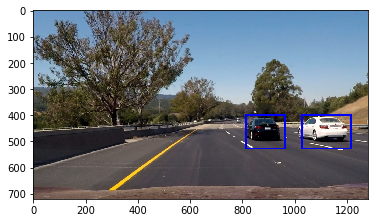

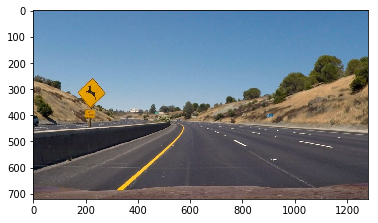

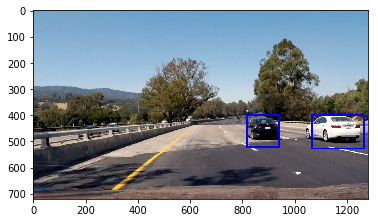

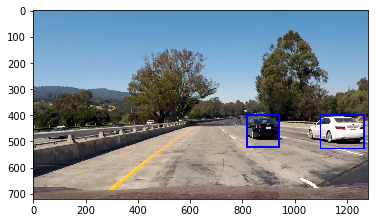

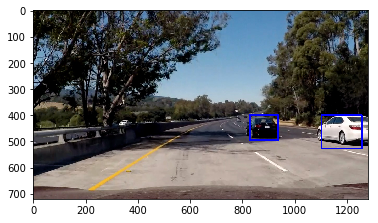

In [29]:
folder = "test_images/"
for file_name in os.listdir("test_images"):
    if file_name.endswith('.jpg'):
        image = mpimg.imread(folder + file_name)
        result = pipeline(image)

        plt.figure()
        plt.imshow(result)
        plt.show()

In [30]:
video_output1 = 'test_video_output.mp4'
video_input1 = VideoFileClip('test_video.mp4')#.subclip(22,26)
processed_video = video_input1.fl_image(pipeline)
%time processed_video.write_videofile(video_output1, audio=False)

[MoviePy] >>>> Building video test_video_output.mp4
[MoviePy] Writing video test_video_output.mp4


 97%|█████████▋| 38/39 [05:07<00:07,  7.77s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output.mp4 

CPU times: user 5min 7s, sys: 100 ms, total: 5min 7s
Wall time: 5min 8s


In [5]:
video_output2 = 'project_video_output.mp4'
video_input2 = VideoFileClip('project_video.mp4')
processed_video = video_input2.fl_image(pipeline)
%time processed_video.write_videofile(video_output2, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [2:40:43<00:07,  7.72s/it] 


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 2h 40min 41s, sys: 3.78 s, total: 2h 40min 45s
Wall time: 2h 40min 44s
